<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importation-des-modules" data-toc-modified-id="Importation-des-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importation des modules</a></span></li><li><span><a href="#Importation-du-dataset" data-toc-modified-id="Importation-du-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importation du dataset</a></span></li><li><span><a href="#Y-a-t-il-des-doublons ?" data-toc-modified-id="Y-a-t-il-des-doublons ?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Y a-t-il des doublons ?</a></span></li><li><span><a href="#Doublons-par-député…" data-toc-modified-id="Doublons-par-député…-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Doublons par député…</a></span></li><li><span><a href="#Ajout-de-la-colonne-“nb_exemplaires”-et-réduction-du-nombre-de-lignes" data-toc-modified-id="Ajout-de-la-colonne-“nb_exemplaires”-et-réduction-du-nombre-de-lignes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ajout de la colonne “nb_exemplaires” et réduction du nombre de lignes</a></span></li><li><span><a href="#Doublons-par-parti" data-toc-modified-id="Doublons-par-parti-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Doublons par parti</a></span></li><li><span><a href="#Les-factures-gonflées" data-toc-modified-id="Les-factures-gonflées-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Les factures gonflées</a></span></li><li><span><a href="#Y-a-t-il-une-corrélation-entre-la-valeur-d’une-facture-et-le-nombre-de-fois-où-elle-est-dupliquée ?" data-toc-modified-id="Y-a-t-il-une-corrélation-entre-la-valeur-d’une-facture-et-le-nombre-de-fois-où-elle-est-dupliquée ?-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Y a-t-il une corrélation entre la valeur d’une facture et le nombre de fois où elle est dupliquée ?</a></span></li></ul></div>

In [1]:
# Brazil's House of Deputies Reimbursements

Dans ce document, je me propose d’étudier une base de données qui a trait aux factures enregistrées par les députés brésiliens.

In [ ]:
En dessous, en anglais, le texte qui accompagnait le dataset :
    
Acknowledgments:

This data is from dadosabertos.camara.leg.br

** Inspiration:**

I have only slightly fiddled with the dataset, but there are some funny patterns to say the least.
Brazil faces a huge problem with corruption and neglect with public funds, this dataset helps to show that.

I invite fellow kagglers to toy with the dataset, try to identify suspicious spendings as well as odd patterns.

bugged_date: (binary) identify whether date had issues
receipt_date: (datetime) receipt date // (int year) for when bugged_date == 1
deputy_id: (deputy_id) id number. (didnt check if it changed across year/legislation period for deputies)
political_party: (string) deputy political party
state_code: (string) Brazil's state that elected the deputy
deputy_name: (string)
receipt_social_security_number: might be a persons SS number (11 digits long) or a business id number (14 digits long). Many cases with issues.
receipt_description: (str / classes) class of spending under which the receipt fits
establishment_name: (string)
receipt_value: (int) $BR, 3BR$ ~ 1USD

# Importation des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Importation du dataset

J’importe et j’explore le dataset intitulé “Brazil’s House of Deputies Reimbursements” (“Remboursement des frais de la Chambre des Députés du Brésil”).

In [42]:
df = pd.read_parquet('deputies_dataset.parquet')

La première chose que je fais est de vérifier s’il y a des valeurs manquantes.

In [43]:
df.isna().sum()

bugged_date                            0
receipt_date                           0
deputy_id                              0
political_party                        0
state_code                             0
deputy_name                            0
receipt_social_security_number    520952
receipt_description                    0
establishment_name                     0
receipt_value                          0
dtype: int64

Il y a un certain nombre de valeurs manquantes dans la colonne “receipt_social_security_number”…
Que représentent-ils dans le dataset ?

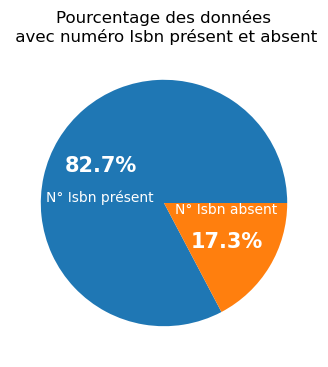

In [6]:
plt.figure(figsize = (4, 4))
secteurs, textes, pourcentages = plt.pie(df['receipt_social_security_number'].isna().value_counts(),
        labels = ['N° Isbn présent', 'N° Isbn absent'], autopct = '%.1f%%',
       labeldistance = 0.1)
plt.setp(pourcentages, fontweight = "bold", color = "white", fontsize = 15)
plt.setp(textes, color = "white")
plt.title("Pourcentage des données\n avec numéro Isbn présent et absent");

Ces nombres Isbn manquants sont en nombre important : je les garde.

In [529]:
# Je regarde le type des colonnes et l’occupation de la mémoire
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014902 entries, 0 to 3014901
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   bugged_date                     int64  
 1   receipt_date                    object 
 2   deputy_id                       int64  
 3   political_party                 object 
 4   state_code                      object 
 5   deputy_name                     object 
 6   receipt_social_security_number  float64
 7   receipt_description             object 
 8   establishment_name              object 
 9   receipt_value                   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1.3 GB


Un certain nombre de colonnes ont pour type “Object”.
Je vais faire des conversions dans le type approprié.
Mais avant cela je vais regarder comment sont ces “bugged_date”…

In [7]:
df.loc[df['bugged_date'] == True, "receipt_date"]

102        2013
107        2013
108        2013
126        2013
127        2013
           ... 
3008451    2009
3012983    2009
3013142    2009
3014370    2009
3014650    2009
Name: receipt_date, Length: 49531, dtype: object

Il n’y a que l’année qui est renseigné… C’est la raison pour laquelle lors d’une conversion en type
datetime, elles sont ajoutées au premier janvier.

Y a-t-il d’autres enregistrements signalés comme non-buggués qui ont cette caractéristique ?

In [64]:
df.loc[df['bugged_date'] == False, "receipt_date"].str.match("^\d{4}$").sum()

0

Apparemment non.

À présent, je fais des conversions pour alléger le dataset

In [44]:
df['receipt_social_security_number'] = df['receipt_social_security_number'].astype('Int64')

In [45]:
df['receipt_date'] = pd.to_datetime(df['receipt_date'])

Je transforme les données de type “object” en type “string”
col_string = df.select_dtypes('object')
df[col_string.columns] = col_string.astype('string')

In [533]:
# Je vérifie que la base de données a bien diminué en poids…
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014902 entries, 0 to 3014901
Data columns (total 10 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   bugged_date                     int64         
 1   receipt_date                    datetime64[ns]
 2   deputy_id                       int64         
 3   political_party                 string        
 4   state_code                      string        
 5   deputy_name                     string        
 6   receipt_social_security_number  Int64         
 7   receipt_description             string        
 8   establishment_name              string        
 9   receipt_value                   int64         
dtypes: Int64(1), datetime64[ns](1), int64(3), string(5)
memory usage: 232.9 MB


In [ ]:
# Cette base de données couvre-t-elle quelle période de temps ?

In [21]:
(df.loc[df['bugged_date'] == False, 'receipt_date'].min(), df.loc[df['bugged_date'] == False, 'receipt_date'].max())

(Timestamp('2009-01-01 00:00:00'), Timestamp('2017-10-24 17:56:47'))

Le premier enregistrement aurait eu lieu le 1er janvier 2009 et le dernier, le 24 octobre 2017.

Il manque le nombre de jours présents de chaque député à la députation pour pouvoir comparer les sommes dépensées.
Puis-je le déduire ? Est-ce que les temps de députation sont continus ou discontinus ? Les élections législatives ont lieu tous les quatre ans au Brésil. Leurs dates sont le 5 octobre 2014, le 7 octobre 2018 et le 3 octobre 2010.

In [46]:
# Je vais utiliser une portion du dataset plus réduite. D’abord je laisse tomber les dates bugguées.
(
    df_dates := df[df['bugged_date'] == False][['receipt_date', 'deputy_name']]
)

,receipt_date,deputy_name
0,2013-03-27,Abelardo Camarinha
1,2013-07-24,Abelardo Camarinha
2,2013-02-17,Abelardo Camarinha
3,2013-03-15,Abelardo Camarinha
4,2013-01-27,Abelardo Camarinha
...,...,...
3014897,2009-12-22,Zonta
3014898,2009-08-24,Zonta
3014899,2009-12-15,Zonta
3014900,2009-08-12,Zonta


In [47]:
# Je trie le tableau par député et par date
(
    df_dates := df_dates.sort_values(['deputy_name', 'receipt_date'])
)

,receipt_date,deputy_name
1068366,2015-01-09 00:00:00,Abel Mesquita Jr.
1068329,2015-02-02 00:00:00,Abel Mesquita Jr.
1068420,2015-02-02 00:00:00,Abel Mesquita Jr.
1068330,2015-02-04 00:00:00,Abel Mesquita Jr.
1068545,2015-02-04 00:00:00,Abel Mesquita Jr.
...,...,...
1225609,2015-01-13 00:00:00,Íris De Araújo
1225608,2015-01-14 00:00:00,Íris De Araújo
1225615,2015-01-19 00:00:00,Íris De Araújo
1225616,2015-01-19 00:00:00,Íris De Araújo


In [49]:
# Et je calcule l’intervalle entre chaque date de facture pour chaque député
# et je m’attarde sur les intervalles supérieures à quatre ans

quatre_ans = pd.Timedelta("1460 days")

df_dates['date_suivante'] = df_dates.groupby('deputy_name')['receipt_date'].transform(lambda x : x.shift(-1))

In [50]:
# La dernière date pour chaque député n’a pas de “date_suivante”. Je remplis donc avec la date_courante
df_dates['date_suivante'] = np.where(df_dates['date_suivante'].isna(),
                                     df_dates['receipt_date'],
                                     df_dates['date_suivante'])

In [51]:
df_dates['difference'] = df_dates['date_suivante'] - df_dates['receipt_date']

In [52]:
df_dates['difference']

1068366   24 days 00:00:00
1068329    0 days 00:00:00
1068420    2 days 00:00:00
1068330    0 days 00:00:00
1068545    1 days 00:00:00
                ...       
1225609    1 days 00:00:00
1225608    5 days 00:00:00
1225615    0 days 00:00:00
1225616    7 days 16:16:05
1225614    0 days 00:00:00
Name: difference, Length: 2965371, dtype: timedelta64[ns]

Je vais ajouter une colonne interruption qui me signalera une interruption de plus de quatre ans

In [53]:
df_dates['interruption'] = df_dates['difference'] > quatre_ans

La date minimum et la date maximum pour chaque député me serviront pour le calcul.

In [54]:
df_dates['min'] = df_dates.groupby('deputy_name')['receipt_date'].transform('min')

df_dates['max'] = df_dates.groupby('deputy_name')['receipt_date'].transform('max')

In [55]:
df_dates

,receipt_date,deputy_name,date_suivante,difference,interruption,min,max
1068366,2015-01-09 00:00:00,Abel Mesquita Jr.,2015-02-02 00:00:00,24 days 00:00:00,False,2015-01-09,2017-10-05 00:00:00
1068329,2015-02-02 00:00:00,Abel Mesquita Jr.,2015-02-02 00:00:00,0 days 00:00:00,False,2015-01-09,2017-10-05 00:00:00
1068420,2015-02-02 00:00:00,Abel Mesquita Jr.,2015-02-04 00:00:00,2 days 00:00:00,False,2015-01-09,2017-10-05 00:00:00
1068330,2015-02-04 00:00:00,Abel Mesquita Jr.,2015-02-04 00:00:00,0 days 00:00:00,False,2015-01-09,2017-10-05 00:00:00
1068545,2015-02-04 00:00:00,Abel Mesquita Jr.,2015-02-05 00:00:00,1 days 00:00:00,False,2015-01-09,2017-10-05 00:00:00
...,...,...,...,...,...,...,...
1225609,2015-01-13 00:00:00,Íris De Araújo,2015-01-14 00:00:00,1 days 00:00:00,False,2009-03-18,2015-01-26 16:16:05
1225608,2015-01-14 00:00:00,Íris De Araújo,2015-01-19 00:00:00,5 days 00:00:00,False,2009-03-18,2015-01-26 16:16:05
1225615,2015-01-19 00:00:00,Íris De Araújo,2015-01-19 00:00:00,0 days 00:00:00,False,2009-03-18,2015-01-26 16:16:05
1225616,2015-01-19 00:00:00,Íris De Araújo,2015-01-26 16:16:05,7 days 16:16:05,False,2009-03-18,2015-01-26 16:16:05


In [56]:
# Je transforme df_dates['difference'] en entier
df_dates['difference'] = df_dates['difference'].astype(str)

df_dates['difference'] = df_dates['difference'].str.extract('(^[0-9]+)').astype('Int32')

Je vais sélectionner les députés qui sont concernés par l’interruption de mandat.

In [ ]:
(
    deputes_interruption := df_dates[df_dates['difference'] > 1460]['deputy_name'].to_list()
)

Il n’y a que pour ces neuf députés qu’il y a pu y avoir une interruption dans leur députation.
(D’ailleurs pour la plupart, la différence est de quasiment quatre ans.)
Je vais calculer la date de fin du premier mandat et la date de début du second mandat.

In [57]:
for depute in deputes_interruption:
    fin_premier_mandat = df_dates.loc[(df_dates['deputy_name'] == depute) & df_dates['interruption'], 'receipt_date'].values[0]
    df_dates.loc[df_dates['deputy_name'] == depute, 'fin_premier_mandat'] = fin_premier_mandat

for depute in deputes_interruption:
    debut_deuxieme_mandat = df_dates.loc[(df_dates['deputy_name'] == depute) & df_dates['interruption'], 'date_suivante'].values[0]
    df_dates.loc[df_dates['deputy_name'] == depute, 'deb_deuxieme_mandat'] = debut_deuxieme_mandat

Je vais donc faire la somme de la première période jusqu’à l’interruption et de la deuxième période à partir
de la reprise des factures pour ces neuf députés.
Pour tous les autres, je vais faire la différence entre la date maximum et la date minimum
pour connaître leur nombre de jours de présence en tant que député.

In [58]:
df_dates['periode'] = np.where(df_dates['deputy_name'].isin(deputes_interruption),
                               (df_dates['fin_premier_mandat'] - df_dates['min']) +\
                               (df_dates['max'] - df_dates['deb_deuxieme_mandat']),
                               df_dates['max'] - df_dates['min'])

Je simplifie le dataframe contenant la période de députation avant de le fusionner avec le dataframe principal.

In [59]:
df_dates = df_dates[['deputy_name', 'periode']]

In [60]:
df_dates = df_dates.drop_duplicates().set_index('deputy_name')

In [61]:
df_dates

,periode
deputy_name,
Abel Mesquita Jr.,1000 days 00:00:00
Abelardo Camarinha,2095 days 12:48:43
Abelardo Lupion,2219 days 17:05:41
Acelino Popó,1455 days 00:00:00
Acácio Júnior,12 days 00:00:00
...,...
Átila A. Nunes,22 days 00:00:00
Átila Lins,3107 days 00:00:00
Átila Lira,3141 days 14:32:45


In [62]:
# Je vais transformer la période en entier.

df_dates['periode'] = df_dates['periode'].astype('str').str.extract('(^\d+)').astype('Int32')

In [63]:
(df := df.join(df_dates, on = 'deputy_name'))

,bugged_date,receipt_date,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_description,establishment_name,receipt_value,periode
0,0,2013-03-27,1772,PSB,SP,Abelardo Camarinha,3530749000139,Fuels and lubricants.,AUTO POSTO 314 NORTE LTDA,70,2095
1,0,2013-07-24,1772,PSB,SP,Abelardo Camarinha,8202116000115,Fuels and lubricants.,AUTO POSTO AEROPORTO LTDA,104,2095
2,0,2013-02-17,1772,PSB,SP,Abelardo Camarinha,8202116000115,Fuels and lubricants.,AUTO POSTO AEROPORTO LTDA,100,2095
3,0,2013-03-15,1772,PSB,SP,Abelardo Camarinha,8202116000115,Fuels and lubricants.,AUTO POSTO AEROPORTO LTDA,100,2095
4,0,2013-01-27,1772,PSB,SP,Abelardo Camarinha,8202116000115,Fuels and lubricants.,AUTO POSTO AEROPORTO LTDA,77,2095
...,...,...,...,...,...,...,...,...,...,...,...
3014897,0,2009-12-22,1712,PP,SC,Zonta,7575651000159,Airline tickets,Cia Aérea - GOL,993,905
3014898,0,2009-08-24,1712,PP,SC,Zonta,7575651000159,Airline tickets,Cia Aérea - GOL,588,905
3014899,0,2009-12-15,1712,PP,SC,Zonta,7575651000159,Airline tickets,Cia Aérea - GOL,773,905
3014900,0,2009-08-12,1712,PP,SC,Zonta,7575651000159,Airline tickets,Cia Aérea - GOL,508,905


In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014902 entries, 0 to 3014901
Data columns (total 11 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   bugged_date                     int64         
 1   receipt_date                    datetime64[ns]
 2   deputy_id                       int64         
 3   political_party                 object        
 4   state_code                      object        
 5   deputy_name                     object        
 6   receipt_social_security_number  Int64         
 7   receipt_description             object        
 8   establishment_name              object        
 9   receipt_value                   int64         
 10  periode                         Int32         
dtypes: Int32(1), Int64(1), datetime64[ns](1), int64(3), object(5)
memory usage: 247.3+ MB


# Y a-t-il des doublons ?

In [24]:
print(f"Il y a {df.duplicated().sum():,} doublons.")

Il y a 169,252 doublons.


Hélas oui. Beaucoup même. Est-ce que si on enlève la date, on se retrouve avec encore plus de doublons ?

In [618]:
print(f"Il y a {df.duplicated(subset = df.columns.drop(['receipt_date'])).sum():,} doublons.")

Il y a 1,095,978 doublons.


Si on enlève la date, on se retrouve avec dix fois plus de doublons.
Cela dit, il est possible qu’à des dates différentes, deux factures peuvent être identiques… n’est-ce pas ?

Je vais à présenter étudier l’évolution du phénomène “doublons” au cours du temps.

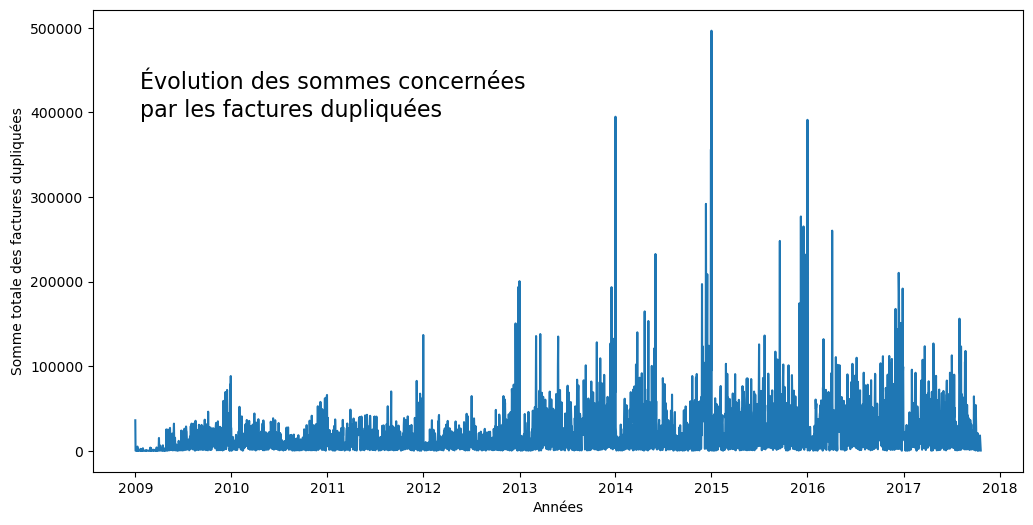

In [88]:
plt.figure(figsize = (12, 6))
plt.plot(df[df.duplicated()].set_index('receipt_date').resample('D')['receipt_value'].sum())
plt.xlabel('Années')
plt.ylabel('Somme totale des factures dupliquées')
plt.title("Évolution des sommes concernées\npar les factures dupliquées", loc = 'left', x = 0.05, y = 0.75,
         fontsize = 16);

On constate que le phénomène des “factures dupliquées” s’est amplifié au cours du temps,
et notamment à partir 2013…

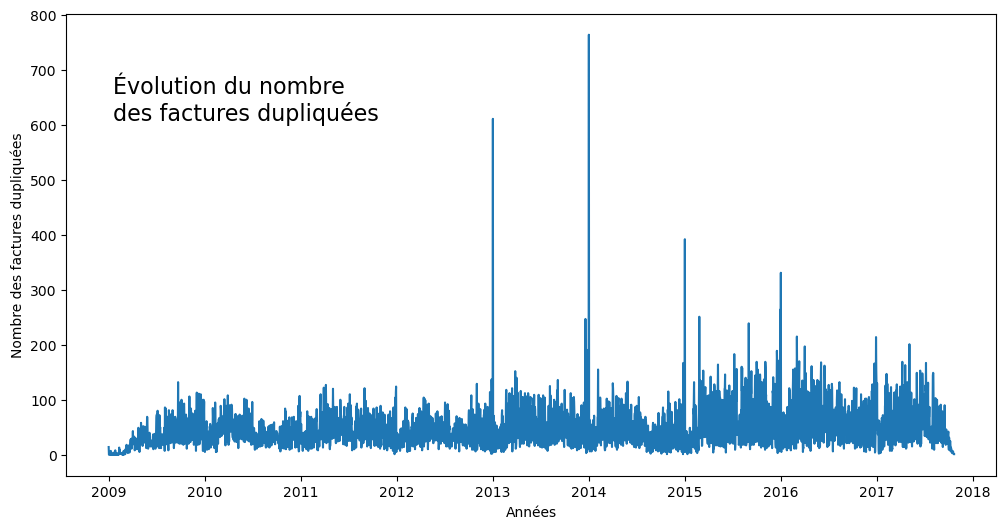

In [91]:
plt.figure(figsize = (12, 6))
plt.plot(df[df.duplicated()].set_index('receipt_date').resample('D')['receipt_value'].count())
plt.xlabel('Années')
plt.ylabel('Nombre des factures dupliquées')
plt.title("Évolution du nombre\ndes factures dupliquées", loc = 'left', x = 0.05, y = 0.75,
         fontsize = 16);

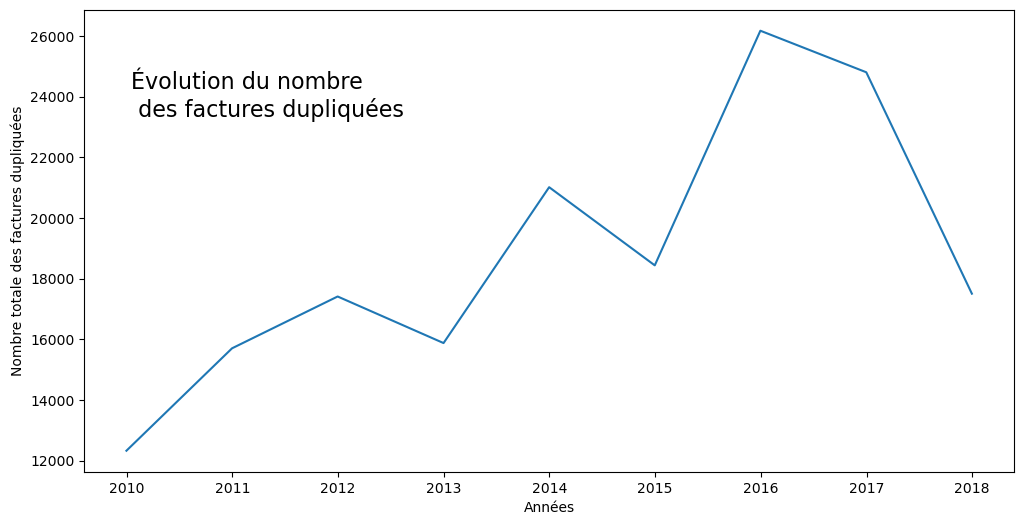

In [93]:
plt.figure(figsize = (12, 6))
plt.plot(df[df.duplicated()].set_index('receipt_date').resample('Y')['receipt_value'].count())
plt.xlabel('Années')
plt.ylabel('Nombre totale des factures dupliquées')
plt.yticks()
plt.title("Évolution du nombre \n des factures dupliquées", loc = 'left', x = 0.05, y = 0.75,
         fontsize = 16);

Mais à partir de 2016, il y a de moins en moins de factures dupliquées… Se serait-on attaqué au problème ?

# Doublons par député…

Je vais regarder maintenant le nombre de doublons par député.

In [64]:
(
    factures_dupliquées_député := df.groupby(['deputy_name', df.duplicated()]).size().loc[(slice(None), True)].sort_values(ascending = False)
)

deputy_name
Jorge Tadeu Mudalen     4404
Bonifácio De Andrada    2434
Júlio Delgado           2102
Vilson Covatti          1649
Henrique Fontana        1590
                        ... 
Moroni Torgan              1
Jorge Alberto              1
Márcio Biolchi             1
Ernandes Amorim            1
Psol                       1
Length: 1116, dtype: int64

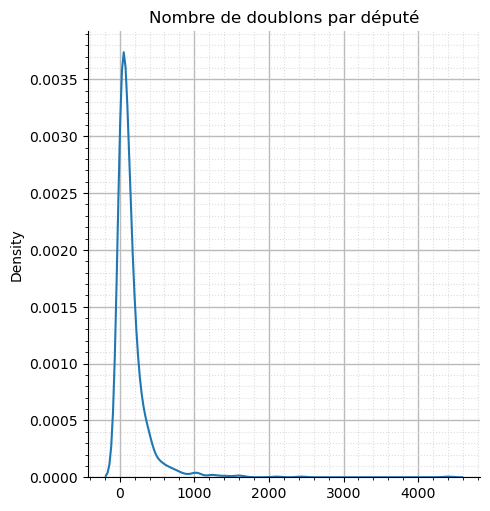

In [557]:
sns.displot(data = factures_dupliquées_député, kind = 'kde')
plt.grid(which = 'major', color = '#BBBBBB', linewidth = 1)
plt.grid(which = 'minor', color = '#DDDDDD', linestyle = ':', linewidth = 0.8)
plt.minorticks_on()
plt.title('Nombre de doublons par député');

On trouve une distribution asymétrique positive avec la plupart des valeurs entre 0 et 500
et une longue queue constituée de milliers de doublons

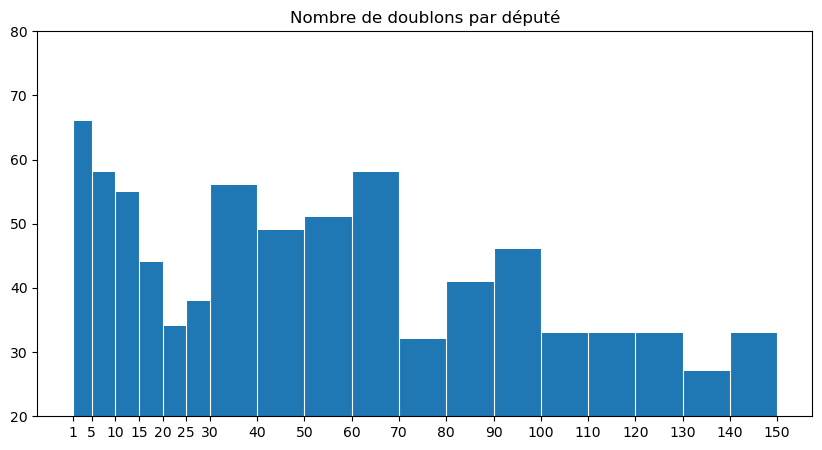

In [559]:
# Je vais utiliser un histogramme
plt.figure(figsize = (10, 5))
n, bins, patches = plt.hist(factures_dupliquées_député[factures_dupliquées_député < 150],
                            bins = [1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150])
plt.xticks(bins)
plt.ylim([20, 80])
plt.grid(axis = 'x', color = 'white')
plt.title('Nombre de doublons par député');

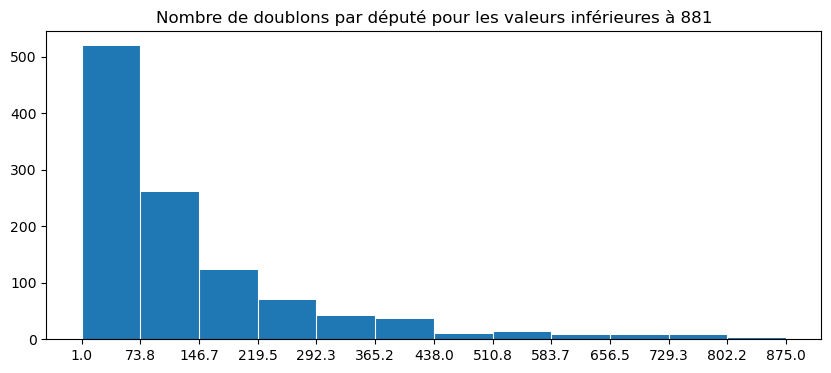

In [558]:
plt.figure(figsize = (10, 4))
n, bins, patches = plt.hist(factures_dupliquées_député[factures_dupliquées_député < 881], bins = 'sturges')
plt.xticks(bins)
plt.grid(axis = 'x', color = 'w')
plt.title('Nombre de doublons par député pour les valeurs inférieures à 881');

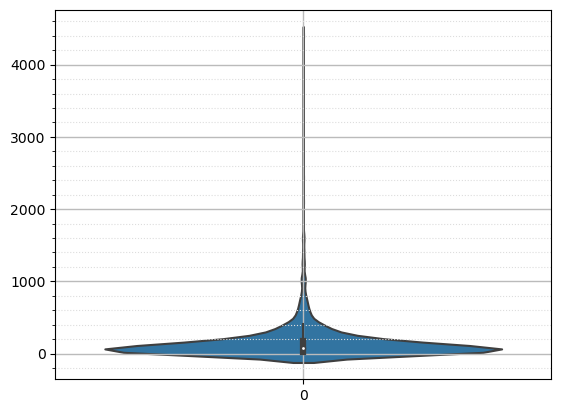

In [24]:
sns.violinplot(data = factures_dupliquées_député)
plt.grid(which = 'major', color = '#BBBBBB', linewidth = 1)
plt.grid(which = 'minor', color = '#DDDDDD', linestyle = ':', linewidth = 0.8)
plt.minorticks_on()

In [560]:
print(f'La médiane des valeurs est {factures_dupliquées_député.median():.0f}.')

La médiane des valeurs est 84.


Ce que l’on retrouve dans le diagramme en violon : on voit que l’ensemble des valeurs sont entre 0 et 438 copies.
Ce qui est déjà beaucoup…

# Ajout de la colonne “nb_exemplaires” et réduction du nombre de lignes

In [65]:
# Et, aussi important combien y a-t-il de doublons par facture (plus de un…) ?
# Je vais donc compter pour chaque facture le nombre de fois où elle est présente
(
    df := df.groupby(df.columns.tolist(), as_index = False).size()\
    .sort_values(by = 'size', ascending = False).rename(columns = {'size': 'nb_exemplaires'})
)

,bugged_date,receipt_date,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_description,establishment_name,receipt_value,periode,nb_exemplaires
119350,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,705,44
990439,0,2012-12-31,1744,PODE,MG,Ademir Camilo,7575651000159,Airline tickets,Cia Aérea - GOL,106,3128,44
1551457,0,2015-02-25,1703,PR,PB,Wellington Roberto,2012862000160,Airline tickets,Cia Aérea - TAM,296,3123,39
436531,0,2010-12-27,1332,PHS,AL,Givaldo Carimbão,2012862000160,Airline tickets,Cia Aérea - TAM,336,3125,37
436970,0,2010-12-28,1531,PCDOB,BA,Alice Portugal,7575651000159,Airline tickets,Cia Aérea - GOL,218,3162,36
...,...,...,...,...,...,...,...,...,...,...,...,...
792386,0,2012-04-08,1729,PT,PI,Nazareno Fonteles,72820822002769,Maintenance of Office,SKY,114,1842,1
792385,0,2012-04-08,1710,PT,BA,Zezéu Ribeiro,75021000257,Fuels and lubricants.,AUTO POSTO FLOR DA CHAPADA LTDA,147,1979,1
792384,0,2012-04-08,1706,PT,PA,Zé Geraldo,7575651000159,Airline tickets,Cia Aérea - GOL,480,3152,1
792383,0,2012-04-08,1693,PSC,PR,Takayama,81894297000420,Fuels and lubricants.,POSTO MARU LTDA,50,3203,1


La nouvelle colonne est de type int64 ce qui est bien excessif

In [68]:
df['nb_exemplaires'] = pd.to_numeric(df['nb_exemplaires'], downcast = 'unsigned')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326985 entries, 119350 to 2326984
Data columns (total 12 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   bugged_date                     int64         
 1   receipt_date                    datetime64[ns]
 2   deputy_id                       int64         
 3   political_party                 object        
 4   state_code                      object        
 5   deputy_name                     object        
 6   receipt_social_security_number  Int64         
 7   receipt_description             object        
 8   establishment_name              object        
 9   receipt_value                   int64         
 10  periode                         Int32         
 11  nb_exemplaires                  uint8         
dtypes: Int32(1), Int64(1), datetime64[ns](1), int64(3), object(5), uint8(1)
memory usage: 210.8+ MB


In [98]:
# Quelle est la proportion de doublons par rapport à ceux qui sont en unique exemplaire ?

In [70]:
(df['nb_exemplaires'] > 1).value_counts()

False    2210628
True      116357
Name: nb_exemplaires, dtype: int64

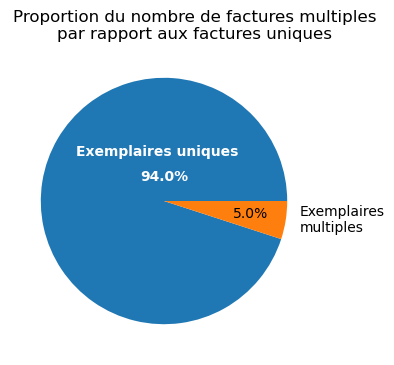

In [637]:
plt.figure(figsize = (6, 4))
portions, textes, percents = plt.pie((df['nb_exemplaires'] > 1).value_counts(),
                                  labels = ['Exemplaires uniques', 'Exemplaires\nmultiples'], 
                                  labeldistance = 1.1, autopct = '%d.0%%')
plt.title('Proportion du nombre de factures multiples\npar rapport aux factures uniques', loc = 'center', x = 0.6)
positions_label = [(0.6, 0.4), (1.1, -0.15)]
positions_percent = [(0, 0.2), (0.7, -0.1)]
fontweights = ['bold', 'normal']
colors = ['white', 'black']

for texte, position_label, fontweight, color, percent, position_percent \
in zip(textes, positions_label, fontweights, colors, percents, positions_percent):
    plt.setp(texte, position = position_label, fontweight = fontweight, color = color)
    plt.setp(percent, position = position_percent, fontweight = fontweight, color = color)

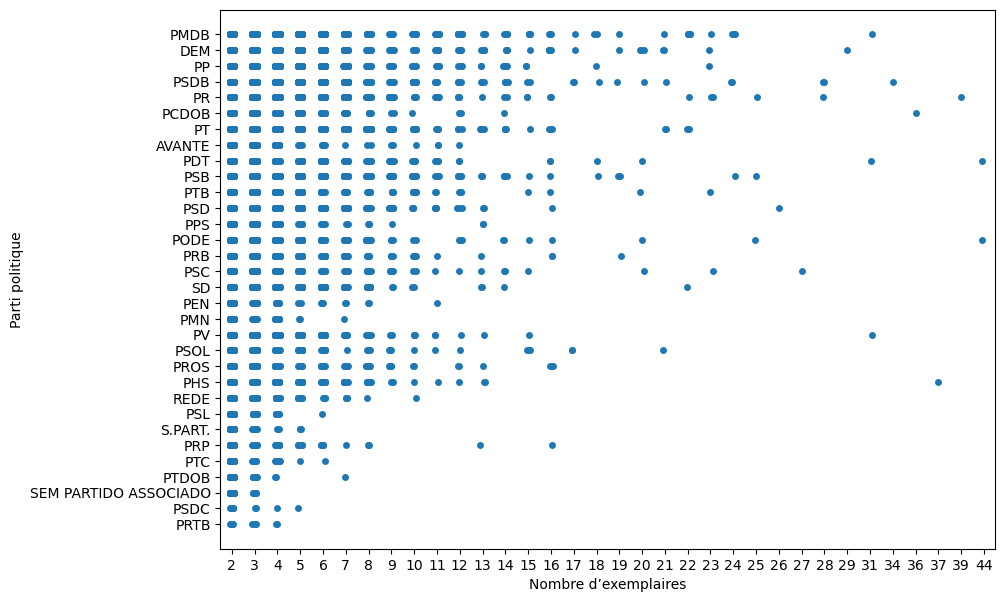

In [71]:
# Le phénomène parait minoritaire mais hélas il semble concerner tous les partis…
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
sns.stripplot(data = df.query('nb_exemplaires > 1'), y = 'political_party', x = 'nb_exemplaires', ax = ax, orient = 'v')
ax.set_xlabel('Nombre d’exemplaires')
ax.set_ylabel('Parti politique');

In [28]:
# Y a-t-il des partis où il n’y a pas eu de factures doublonnées ?

In [71]:
df[df['nb_exemplaires'] > 1].groupby('political_party').size()

political_party
AVANTE                     757
DEM                       7614
PCDOB                     2499
PDT                       4011
PEN                        383
PHS                       1406
PMDB                     14023
PMN                        219
PODE                      2126
PP                       11000
PPS                       1571
PR                        9347
PRB                       2181
PROS                      1279
PRP                        317
PRTB                        11
PSB                       7728
PSC                       1693
PSD                       5866
PSDB                     12055
PSDC                        15
PSL                        311
PSOL                       985
PT                       18232
PTB                       3426
PTC                        157
PTDOB                       83
PV                        3270
REDE                       565
S.PART.                    375
SD                        2782
SEM PARTIDO ASSOCIADO  

Non, aucun n’est à zéro…

In [ ]:
# Y a-t-il un lien entre le fait qu’une facture soit dupliquée et la présence ou non d’un numéro de sécurité sociale ?

In [72]:
df.loc[df['nb_exemplaires'] > 1, 'receipt_social_security_number'].isna().sum()

0

Et ils ont tous leur numéro de sécurité social renseigné.

In [ ]:
# Et la date bugguée ?

In [78]:
(
    doublons_date_bugguée := df.loc[df['nb_exemplaires'] > 1, 'bugged_date'].value_counts()
)

False    116083
True        274
Name: bugged_date, dtype: int64

In [ ]:
# Et leur date pour la grande majorité est non bugguée.

In [ ]:
# Sont-il plus le fait d’un député, d’une entreprise, d’un parti, d’un état ?

In [ ]:
# Nous avons vu que certains députés ont beaucoup de doublons.

In [653]:
(
doublons_depute := df[df['nb_exemplaires']>1].groupby('deputy_name').agg({'nb_exemplaires': lambda x: (x -1).sum(), 'political_party': lambda x : x.unique()[0]})\
    .rename(columns = {'nb_exemplaires': 'nb_doublons'})
)

,nb_doublons,political_party
deputy_name,,
Abel Mesquita Jr.,254,DEM
Abelardo Camarinha,95,PSB
Abelardo Lupion,77,DEM
Acelino Popó,134,PRB
Acélio Casagrande,34,PMDB
...,...,...
Átila A. Nunes,1,PMDB
Átila Lins,25,PSD
Átila Lira,66,PSB


In [656]:
doublons_depute = doublons_depute.sort_values('nb_doublons', ascending = False)

In [664]:
doublons_depute[:20]

,nb_doublons,political_party
deputy_name,,
Jorge Tadeu Mudalen,4384,DEM
Bonifácio De Andrada,2431,PSDB
Júlio Delgado,2102,PSB
Vilson Covatti,1648,PP
Henrique Fontana,1580,PT
Nelson Meurer,1564,PP
Pepe Vargas,1417,PT
Marco Maia,1407,PT
Vanderlei Macris,1293,PSDB


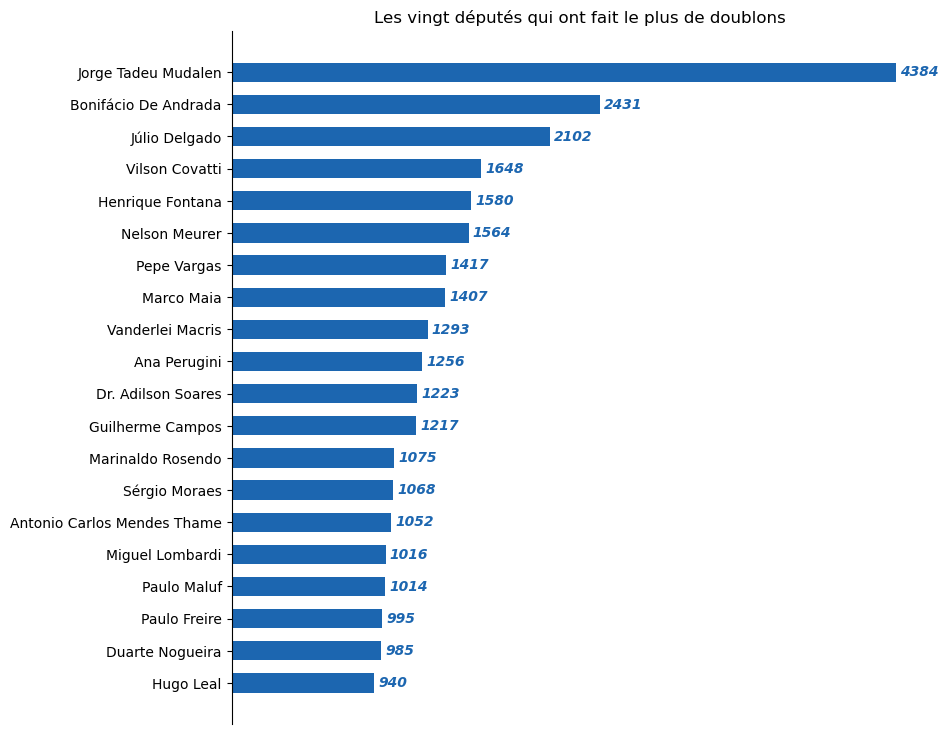

In [673]:
fig, ax = plt.subplots(figsize = (9, 9))
bars = ax.barh(y = list(reversed(doublons_depute[:20].index)),
         width = list(reversed(doublons_depute[:20]['nb_doublons'])), height = 0.6, color = '#1c66b0')
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars, padding = 3, label_type = 'edge', fontstyle = 'italic', color = '#1c66b0',
            fontweight = 'bold')
plt.title('Les vingt députés qui ont fait le plus de doublons');

In [ ]:
Y a-t-il une surreprésentation de certains partis ?

# Doublons par entreprise

In [ ]:
# Seraient-ils plus le fait de certaines entreprises ?

In [81]:
(
    doublons_entreprise := df[df['nb_exemplaires'] > 1].groupby('establishment_name')\
    .size().sort_values(ascending = False)
).head(20)

establishment_name
Cia Aérea - TAM                                                 27546
Cia Aérea - GOL                                                 20356
Cia Aérea - AVIANCA                                              6603
Cia Aérea - AZUL                                                 4066
Conc. Sistema Anhanguera-Bandeirantes S/A                        2083
UNIVIAS                                                          1146
SINPETAXI                                                         841
Cia Aérea - TRIP                                                  837
CONCER                                                            828
Cia Aérea - PASSAREDO                                             801
Cia Aérea - WEBJET                                                766
CAMINHOS DO PARANA S/A                                            716
CONVIAS S/A                                                       689
AUTO PISTA FERNÃO DIAS                                            649
C

Ci-dessus les vingt entreprises avec lesquelles il y a le plus de doublons…

# Doublons par parti

In [678]:
(
doublons_party := df[df['nb_exemplaires'] > 1].groupby('political_party')\
    .agg({'nb_exemplaires': lambda x : (x -1).sum()}).sort_values(by = 'nb_exemplaires', ascending = False)\
    .rename(columns = {'nb_exemplaires': 'nb_doublons'})
)

,nb_doublons
political_party,
PT,25386
PMDB,19807
PSDB,17295
PP,15473
PR,13986
PSB,12214
DEM,11855
PSD,8263
PDT,5788


In [85]:
doublons_party.index.shape

(32,)

In [ ]:
# Quels sont les partis qui ont le plus de députés pour une période de temps donné ?

In [9]:
(
    partis := df['political_party'].unique()
)

array(['PSB', 'DEM', 'PRB', 'PODE', 'PMDB', 'PR', 'PT', 'PP', 'PSDB',
       'REDE', 'PTB', 'PSD', 'PSL', 'PCDOB', 'PDT', 'PSC', 'S.PART.',
       'PV', 'SD', 'PPS', 'PSOL', 'PRP', 'PROS', 'PMN', 'PHS', 'PEN',
       'SEM PARTIDO ASSOCIADO', 'PTDOB', 'AVANTE', 'PSDC', 'PTC', 'PRTB'],
      dtype=object)

In [24]:
print(f"Le nombre total de partis est de {len(partis)}.")

Le nombre total de partis est de 32.


In [31]:
df.loc[df['deputy_name'].isin(doublons_depute.iloc[0:20].index), 'political_party'].value_counts()

PT      36958
PSDB    34853
PP      23507
PSB     22856
PR      16085
DEM     15590
PV      10069
PSD      7202
PTB      6794
PHS      5840
Name: political_party, dtype: int64

# Les factures gonflées

In [18]:
# Combien y a-t-il de postes de dépenses ?

In [19]:
df['receipt_description'].nunique()

21

In [ ]:
# Quels sont ces 21 postes ?

In [20]:
df['receipt_description'].unique()

array(['Fuels and lubricants.',
       'Dissemination of the Parliamentary Activity.', 'Airline tickets',
       'Telephony', 'Postal Services',
       'Renting of motor vehicles or chartering of boats',
       'Maintenance of Office',
       'Consultancies, Researches and Technical Works.', 'Food and Meals',
       'Hosting, except for the Parliamentary in the Federal District.',
       'Rental or Chartering of Motor Vehicles',
       'Security Service Provided By Specialized Company.',
       'Taxi Service, Toll & Parking', 'Land, Sea or River Tickets',
       'Publication Subscription', 'Renting or Chartering of Aircraft',
       'Leasing or Chartering of Boats',
       'Participation in Course, Lecture or Similar Event',
       'Locomotion, Food and Lodging', 'Acquisition of Office Supplies.',
       'Acquisition or Location of Software for Postal Services'],
      dtype=object)

In [ ]:
# Et combien y a-t-il d’entreprises différentes concernées par ces 21 postes de dépenses ?

In [30]:
df.groupby(['receipt_description'])['establishment_name'].count().to_frame()

,establishment_name
receipt_description,
Acquisition of Office Supplies.,1601
Acquisition or Location of Software for Postal Services,2634
Airline tickets,796697
"Consultancies, Researches and Technical Works.",24062
Dissemination of the Parliamentary Activity.,73132
Food and Meals,212036
Fuels and lubricants.,635534
"Hosting, except for the Parliamentary in the Federal District.",49880
"Land, Sea or River Tickets",3938


In [34]:
(
    multi_category := df.set_index(['receipt_description', 'establishment_name'])
)

bugged_date  \
receipt_description                    establishment_name                              
Airline tickets                        Cia Aérea - GOL                             0   
                                       Cia Aérea - GOL                             0   
                                       Cia Aérea - TAM                             0   
                                       Cia Aérea - TAM                             0   
                                       Cia Aérea - GOL                             0   
...                                                                              ...   
Maintenance of Office                  SKY                                         0   
Fuels and lubricants.                  AUTO POSTO FLOR DA CHAPADA LTDA             0   
Airline tickets                        Cia Aérea - GOL                             0   
Fuels and lubricants.                  POSTO MARU LTDA                             0   
Rental or Chartering of Motor Vehicles DS LOCAÇÃODE VEÍCULOS EIRELI-EPP            1   

                                                                        receipt_date  \
receipt_description                    establishment_name                              
Airline tickets                        Cia Aérea - GOL                    2009-09-22   
                                       Cia Aérea - GOL                    2012-12-31   
                                       Cia Aérea - TAM                    2015-02-25   
                                       Cia Aérea - TAM                    2010-12-27   
                                       Cia Aérea - GOL                    2010-12-28   
...                                                                              ...   
Maintenance of Office                  SKY                                2012-04-08   
Fuels and lubricants.                  AUTO POSTO FLOR DA CHAPADA LTDA    2012-04-08   
Airline tickets                        Cia Aérea - GOL                    2012-04-08   
Fuels and lubricants.                  POSTO MARU LTDA                    2012-04-08   
Rental or Chartering of Motor Vehicles DS LOCAÇÃODE VEÍCULOS EIRELI-EPP   2017-01-01   

                                                                         deputy_id  \
receipt_description                    establishment_name                            
Airline tickets                        Cia Aérea - GOL                        1785   
                                       Cia Aérea - GOL                        1744   
                                       Cia Aérea - TAM                        1703   
                                       Cia Aérea - TAM                        1332   
                                       Cia Aérea - GOL                        1531   
...                                                                            ...   
Maintenance of Office                  SKY                                    1729   
Fuels and lubricants.                  AUTO POSTO FLOR DA CHAPADA LTDA        1710   
Airline tickets                        Cia Aérea - GOL                        1706   
Fuels and lubricants.                  POSTO MARU LTDA                        1693   
Rental or Chartering of Motor Vehicles DS LOCAÇÃODE VEÍCULOS EIRELI-EPP       3144   

                                                                        political_party  \
receipt_description                    establishment_name                                 
Airline tickets                        Cia Aérea - GOL                              PDT   
                                       Cia Aérea - GOL                             PODE   
                                       Cia Aérea - TAM                               PR   
                                       Cia Aérea - TAM                              PHS   
                                       Cia Aérea - GOL                            PCDOB   
...                        

In [84]:
premier_quartile = df.groupby('receipt_description')['receipt_value'].transform('quantile', 0.25)
troisieme_quartile = df.groupby('receipt_description')['receipt_value'].transform('quantile', 0.75)
iqr = troisieme_quartile - premier_quartile

maximum = troisieme_quartile + iqr * 1.5

df['outlier'] = df['receipt_value'] > maximum

In [85]:
df

,bugged_date,receipt_date,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_description,establishment_name,receipt_value,periode,nb_exemplaires,outlier
119350,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,705,44,False
990439,0,2012-12-31,1744,PODE,MG,Ademir Camilo,7575651000159,Airline tickets,Cia Aérea - GOL,106,3128,44,False
1551457,0,2015-02-25,1703,PR,PB,Wellington Roberto,2012862000160,Airline tickets,Cia Aérea - TAM,296,3123,39,False
436531,0,2010-12-27,1332,PHS,AL,Givaldo Carimbão,2012862000160,Airline tickets,Cia Aérea - TAM,336,3125,37,False
436970,0,2010-12-28,1531,PCDOB,BA,Alice Portugal,7575651000159,Airline tickets,Cia Aérea - GOL,218,3162,36,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
792386,0,2012-04-08,1729,PT,PI,Nazareno Fonteles,72820822002769,Maintenance of Office,SKY,114,1842,1,False
792385,0,2012-04-08,1710,PT,BA,Zezéu Ribeiro,75021000257,Fuels and lubricants.,AUTO POSTO FLOR DA CHAPADA LTDA,147,1979,1,False
792384,0,2012-04-08,1706,PT,PA,Zé Geraldo,7575651000159,Airline tickets,Cia Aérea - GOL,480,3152,1,False
792383,0,2012-04-08,1693,PSC,PR,Takayama,81894297000420,Fuels and lubricants.,POSTO MARU LTDA,50,3203,1,False


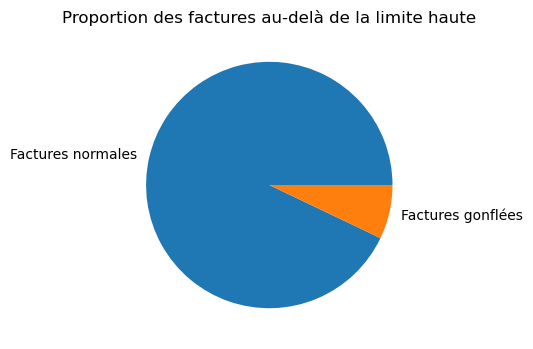

In [38]:
labels = ['Factures normales', 'Factures gonflées']
plt.figure(figsize = (4, 4))
plt.pie(df['outlier'].value_counts(), labels = labels)
plt.title('Proportion des factures au-delà de la limite haute');

In [41]:
print('Le nombre des factures aux montants excessifs est', df['outlier'].sum())

Le nombre des factures aux montants excessifs est 165126


In [1]:
# Dépense totale par code de l’état

In [ ]:
# Quel est la relation entre les factures dupliquées et les montants excessifs ?

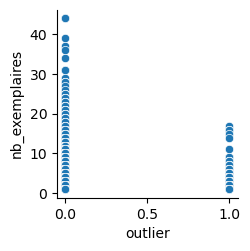

In [86]:
sns.pairplot(data = df, x_vars = 'outlier', y_vars = 'nb_exemplaires');

Les factures qui ne sont pas des “outliers” semblent avoir été plus dupliquées.

# Y a-t-il une corrélation entre la valeur d’une facture et le nombre de fois où elle est dupliquée ?

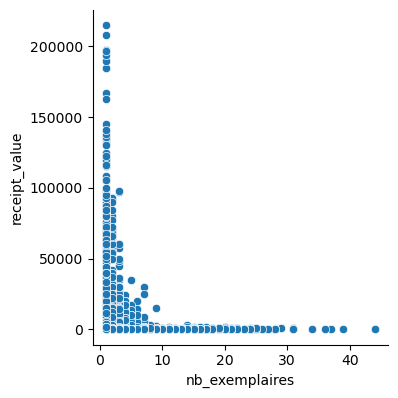

In [87]:
sns.pairplot(data = multi_category, x_vars = 'nb_exemplaires', y_vars = 'receipt_value', height = 4);

In [ ]:
# D’après la figure, il y a au moins une petite corrélation entre le nombre de duplicata et la somme de la facture